<a href="https://colab.research.google.com/github/andreidm92/computer_vision_tasks/blob/main/practice/Lesson15_Full_Augmentations_And_Homography.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 📘 Урок 15
**Тема:** Аугментации: Mosaic, CutMix  
**Мини-OpenCV:** реализация Mosaic и CutMix вручную  
**Линейная алгебра:** Аффинные и проективные преобразования — Проективные преобразования и гомография

## 1. Аугментации: Mosaic, CutMix

### 🔹 Теория
**Mosaic** — техника из YOLOv4, объединяющая 4 изображения в одно. Используется для усиления разнообразия и повышения устойчивости модели.

**Преимущества:**
- Объекты в разных масштабах и контекстах
- Снижение переобучения
- Повышение плотности объектов

**CutMix** — техника наложения части одного изображения на другое. При этом обновляются bounding box'ы.

**Формула CutMix:**
$$
\tilde{x} = x_A \cdot \mathbb{1}_{\text{outside R}} + x_B \cdot \mathbb{1}_{\text{inside R}}
$$
Где $\lambda \sim \text{Beta}(\alpha, \alpha)$ определяет размер вырезанного региона $R$.

## 1. Аугментации: Mosaic и CutMix

Аугментации играют ключевую роль в обучении моделей компьютерного зрения — они расширяют обучающую выборку, повышают обобщающую способность модели и позволяют справляться с переобучением.

### 🔷 Mosaic Augmentation

**Mosaic** — это метод аугментации, предложенный в YOLOv4, при котором из четырёх различных изображений создаётся одно общее изображение, содержащее элементы всех четырёх.

#### 📌 Принцип работы:

- Берутся 4 случайных изображения и соответствующие им аннотации (bounding box'ы).
- Создаётся холст (например, 640×640 пикселей), делится на 4 равные части.
- Каждое изображение уменьшается (с ресайзом) до 1/4 и вставляется в свою четверть холста.
- Bounding box'ы трансформируются в зависимости от новой позиции.

#### 📐 Геометрия:

Если изображение вставляется, например, в **нижнюю правую четверть**, его координаты bbox сдвигаются на:

- $$ x' = x + W/2 $$
- $$ y' = y + H/2 $$

Где \( W, H \) — ширина и высота итогового изображения.

#### ✅ Преимущества:

- Больше объектов на изображении → выше плотность аннотаций.
- Объекты в разных контекстах и масштабах.
- Повышение устойчивости модели к фоновым шумам и изменениям сцены.
- Эффективнее для распознавания **маленьких объектов**.

#### ⚠️ Ограничения:

- Неверные или выходящие за границы bounding box'ы, если не обрезать.
- Может нарушаться контекст сцены.
- Требует ручной обработки аннотаций при реализации вручную.

---

### 🔷 CutMix Augmentation

**CutMix** — это техника, при которой из одного изображения вырезается регион, и он вставляется в другое изображение. Bounding box'ы также объединяются и корректируются.

#### 📌 Принцип работы:

- Берутся два изображения: \( A \) и \( B \)
- Из изображения \( B \) случайно вырезается прямоугольник (регион \( R \))
- Этот регион вставляется в изображение \( A \)
- Bounding box'ы из \( B \), попадающие в регион \( R \), переносятся в итоговое изображение и обрезаются по границам \( R \)
- Bounding box'ы из \( A \) сохраняются

#### 🧮 Математика:

CutMix использует распределение **Beta**:

- Вычисляется значение \( \lambda \sim \text{Beta}(\alpha, \alpha) \)
- Затем определяется ширина и высота вырезаемого региона:

$$
r_w = W \cdot \sqrt{1 - \lambda}, \quad r_h = H \cdot \sqrt{1 - \lambda}
$$

- Итоговое изображение:  
$$
\tilde{x} = x_A \cdot \mathbb{1}_{\text{outside R}} + x_B \cdot \mathbb{1}_{\text{inside R}}
$$

#### ✅ Преимущества:

- Регуляризация модели, схожая с Dropout.
- Улучшение устойчивости модели к локальным признакам.
- Повышение точности классификации и детекции.

#### ⚠️ Особенности реализации:

- Нужно точно рассчитывать координаты вставки и обрезать bbox'ы.
- Нельзя применять к изображению без корректной аннотации.
- Подходит для моделей, где важна устойчивость к частичной окклюзии.

### 🧠 Вопросы для самопроверки:

1. Какой тип аугментации больше подходит для маленьких объектов?
2. В чём отличие влияния Mosaic и CutMix на фон изображения?
3. Почему важно обрезать bbox'ы в CutMix при вставке вырезанного региона?
4. Что даёт использование Beta-распределения в CutMix?



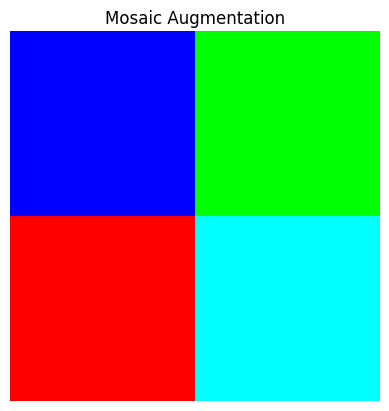

In [3]:
# Пример генерации 4 цветных изображений для Mosaic
import cv2
import numpy as np
import matplotlib.pyplot as plt

def generate_image(color):
    img = np.ones((320, 320, 3), dtype=np.uint8)
    img[:] = color
    return img

images = [
    generate_image((255, 0, 0)),
    generate_image((0, 255, 0)),
    generate_image((0, 0, 255)),
    generate_image((255, 255, 0))
]

canvas = np.zeros((640, 640, 3), dtype=np.uint8)
positions = [(0, 0), (0, 320), (320, 0), (320, 320)]
for img, (y, x) in zip(images, positions):
    canvas[y:y+320, x:x+320] = img

plt.imshow(cv2.cvtColor(canvas, cv2.COLOR_BGR2RGB))
plt.title('Mosaic Augmentation')
plt.axis('off')
plt.show()

## 2. OpenCV: реализация Mosaic и CutMix вручную

[((425, 640, 3), 3, 'foto1.jpeg'), ((198, 255, 3), 3, 'foto2.jpeg'), ((183, 275, 3), 2, 'foto3.jpeg'), ((193, 261, 3), 2, 'foto4.jpeg')]


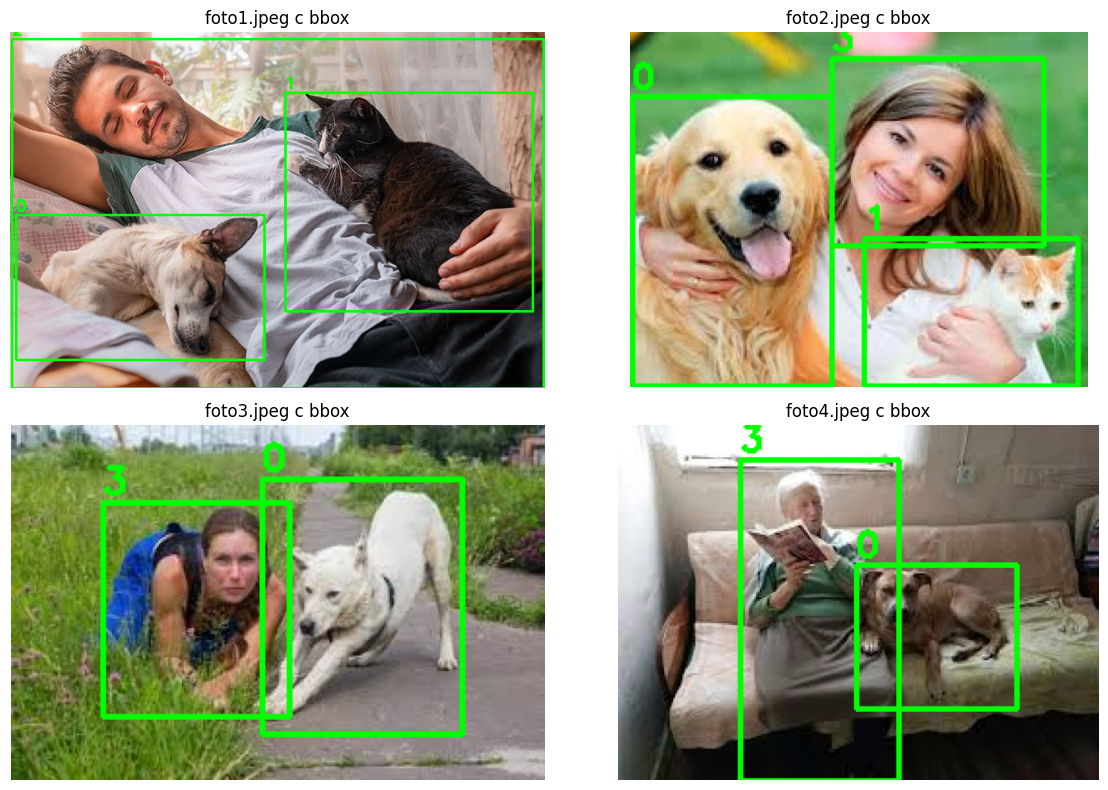

In [6]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Пути к изображениям и аннотациям
images_info = [
    {"img": "/content/foto1.jpeg", "txt": "/content/foto1.txt"},
    {"img": "/content/foto2.jpeg", "txt": "/content/foto2.txt"},
    {"img": "/content/foto3.jpeg", "txt": "/content/foto3.txt"},
    {"img": "/content/foto4.jpeg", "txt": "/content/foto4.txt"},
]

# Функция загрузки и конвертации YOLO-аннотаций
def load_image_and_boxes(img_path, txt_path):
    img = cv2.imread(img_path)
    if img is None:
        raise FileNotFoundError(f"Не удалось загрузить изображение: {img_path}")
    h, w = img.shape[:2]
    boxes = []
    with open(txt_path, "r") as f:
        for line in f:
            cls, x, y, bw, bh = map(float, line.strip().split())
            x1 = int((x - bw / 2) * w)
            y1 = int((y - bh / 2) * h)
            x2 = int((x + bw / 2) * w)
            y2 = int((y + bh / 2) * h)
            boxes.append((int(cls), x1, y1, x2, y2))
    return img, boxes

# Функция отрисовки bbox
def draw_boxes(img, boxes, color=(0, 255, 0)):
    img = img.copy()
    for cls, x1, y1, x2, y2 in boxes:
        cv2.rectangle(img, (x1, y1), (x2, y2), color, 2)
        cv2.putText(img, str(cls), (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)
    return img

# Загружаем изображения и аннотации
loaded_data = []
for info in images_info:
    img, boxes = load_image_and_boxes(info["img"], info["txt"])
    loaded_data.append((img, boxes, Path(info["img"]).name))

# Вывод информации
a = [(img.shape, len(boxes), name) for img, boxes, name in loaded_data]
print(a)

# Визуализация изображений с рамками ДО аугментаций
plt.figure(figsize=(12, 8))
for i, (img, boxes, name) in enumerate(loaded_data):
    img_with_boxes = draw_boxes(img, boxes)
    img_rgb = cv2.cvtColor(img_with_boxes, cv2.COLOR_BGR2RGB)
    plt.subplot(2, 2, i + 1)
    plt.imshow(img_rgb)
    plt.title(f"{name} с bbox")
    plt.axis("off")

plt.tight_layout()
plt.show()


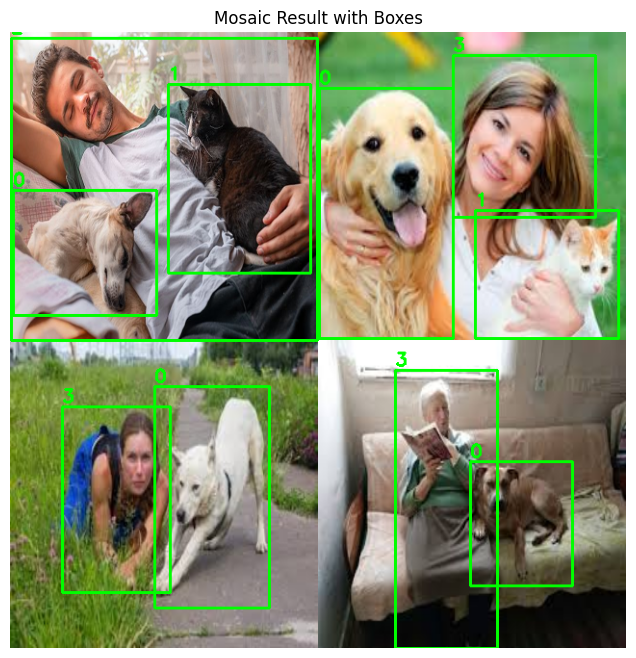

In [7]:
# === МОЗАИКА ===
canvas = np.zeros((640, 640, 3), dtype=np.uint8)
positions = [(0, 0), (0, 320), (320, 0), (320, 320)]
all_boxes = []

for (img, boxes, name), (y_off, x_off) in zip(loaded_data, positions):
    img_resized = cv2.resize(img, (320, 320))
    canvas[y_off:y_off+320, x_off:x_off+320] = img_resized

    scale_x = 320 / img.shape[1]
    scale_y = 320 / img.shape[0]

    for cls, x1, y1, x2, y2 in boxes:
        x1_new = int(x1 * scale_x) + x_off
        y1_new = int(y1 * scale_y) + y_off
        x2_new = int(x2 * scale_x) + x_off
        y2_new = int(y2 * scale_y) + y_off
        all_boxes.append((cls, x1_new, y1_new, x2_new, y2_new))

mosaic_img = draw_boxes(canvas, all_boxes)
plt.figure(figsize=(8, 8))
plt.imshow(cv2.cvtColor(mosaic_img, cv2.COLOR_BGR2RGB))
plt.title("Mosaic Result with Boxes")
plt.axis("off")
plt.show()


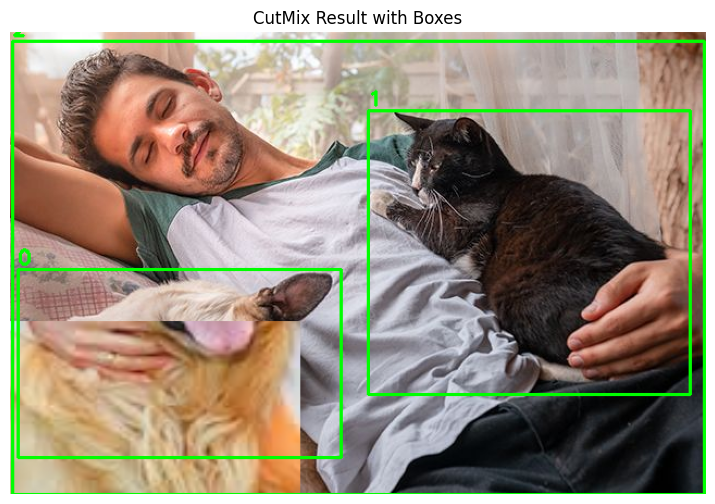

In [8]:
# === CUTMIX ===
img1, boxes1, _ = loaded_data[0]
img2, boxes2, _ = loaded_data[1]

h, w = img1.shape[:2]
lam = np.random.beta(1.0, 1.0)
cut_w = int(w * np.sqrt(1 - lam))
cut_h = int(h * np.sqrt(1 - lam))
cx, cy = np.random.randint(w), np.random.randint(h)

x1 = np.clip(cx - cut_w // 2, 0, w)
y1 = np.clip(cy - cut_h // 2, 0, h)
x2 = np.clip(cx + cut_w // 2, 0, w)
y2 = np.clip(cy + cut_h // 2, 0, h)

# Вырезаем и вставляем регион
cutmix_img = img1.copy()
resized_img2 = cv2.resize(img2, (w, h))
cutmix_img[y1:y2, x1:x2] = resized_img2[y1:y2, x1:x2]

# Объединяем боксы
final_boxes = boxes1.copy()
for cls, bx1, by1, bx2, by2 in boxes2:
    bx1r = int(bx1 * w / img2.shape[1])
    by1r = int(by1 * h / img2.shape[0])
    bx2r = int(bx2 * w / img2.shape[1])
    by2r = int(by2 * h / img2.shape[0])

    if bx1r >= x1 and bx2r <= x2 and by1r >= y1 and by2r <= y2:
        final_boxes.append((cls, bx1r, by1r, bx2r, by2r))

cutmix_img_boxed = draw_boxes(cutmix_img, final_boxes)
plt.figure(figsize=(10, 6))
plt.imshow(cv2.cvtColor(cutmix_img_boxed, cv2.COLOR_BGR2RGB))
plt.title("CutMix Result with Boxes")
plt.axis("off")
plt.show()


## 3. Линейная алгебра: Проективные преобразования и гомография

### 🔹 Теория
**Гомография** — преобразование между двумя плоскостями, определяемое матрицей 3×3.

Общий вид:
$$
\begin{bmatrix}x'\\y'\\1\end{bmatrix} = H \cdot \begin{bmatrix}x\\y\\1\end{bmatrix},
\quad H \in \mathbb{R}^{3\times3}
$$
Используется в компьютерном зрении для:
- Совмещения изображений (stitching)
- Построения панорам
- Устранения перспективных искажений

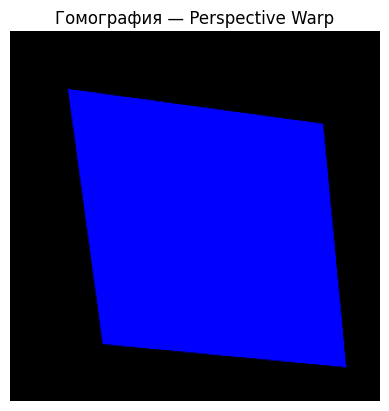

In [9]:
# Пример гомографического преобразования
pts_src = np.array([[0, 0], [319, 0], [319, 319], [0, 319]], dtype=np.float32)
pts_dst = np.array([[50, 50], [270, 80], [290, 290], [80, 270]], dtype=np.float32)
h, status = cv2.findHomography(pts_src, pts_dst)
warped = cv2.warpPerspective(images[0], h, (320, 320))
plt.imshow(cv2.cvtColor(warped, cv2.COLOR_BGR2RGB))
plt.title('Гомография — Perspective Warp')
plt.axis('off')
plt.show()

## 📐 Гомография в OpenCV — Пояснение

Гомография — это проективное преобразование между двумя изображениями одной и той же плоскости. Она используется для коррекции перспективы, совмещения изображений, построения панорам и выравнивания объектов (например, документов).

---

### 🔍 Объяснение

**Исходные точки** (`pts_src`) — это 4 угла прямоугольного изображения размером 320×320 пикселей:
- (0, 0) — левый верхний угол,
- (319, 0) — правый верхний,
- (319, 319) — правый нижний,
- (0, 319) — левый нижний.

**Целевые точки** (`pts_dst`) — это точки, в которые мы хотим отобразить соответствующие углы исходного изображения. Эти точки задают новое положение углов — например, с перспективным искажением.

Функция `cv2.findHomography` вычисляет матрицу гомографии **H**, которая позволяет перенести любую точку из одной плоскости в другую. Она применяется ко всему изображению функцией `cv2.warpPerspective`.

---

### 🧠 Математика

Гомография описывается уравнением:

$$
\begin{bmatrix}
x' \\
y' \\
1
\end{bmatrix}
=
H \cdot
\begin{bmatrix}
x \\
y \\
1
\end{bmatrix}
$$

Где:
- \( (x, y) \) — координаты в исходном изображении,
- \( (x', y') \) — координаты после преобразования,
- \( H \in \mathbb{R}^{3 \times 3} \) — матрица гомографии.

---

### 🧾 Структура матрицы \( H \)

$$
H =
\begin{bmatrix}
h_{11} & h_{12} & h_{13} \\
h_{21} & h_{22} & h_{23} \\
h_{31} & h_{32} & h_{33}
\end{bmatrix}
$$

Особенности гомографии:
- сохраняет **прямые линии**,
- не сохраняет **углы и расстояния**,
- применима только к объектам, находящимся на **одной плоскости**.

---

### 📦 Где применяется гомография?

| Область применения        | Примеры                                  |
|---------------------------|-------------------------------------------|
| Построение панорам        | Совмещение изображений (image stitching) |
| Коррекция перспективы     | Выпрямление досок, экранов, страниц      |
| AR / VR                   | Отображение объектов на поверхности       |
| Робототехника, SLAM       | Связь между кадрами или видами сцены     |

---

### ✅ Вывод

Гомография — это важный инструмент в компьютерном зрении, когда нужно преобразовать изображение плоскости, полученное под одним углом, в вид с другой точки. Она особенно полезна, когда все ключевые точки лежат на одной плоскости: это позволяет "перекидывать" изображение в новую перспективу, устранять искажения и строить швы между кадрами.
